# Notebook for Quality Control demonstration of tonykong.me

This notebook aims for storing calculations and demonstrations of blo related to quality controls in tonykong.me. This notebook will be devided by the date release of a blog article, and will further devide by each of the functions demonstrated in that article.

## Blog on 16 September 2023

### 1. Demonstration of CDF of Gaussian distribution under 1s

In [437]:
#import numpy and matplotlib
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

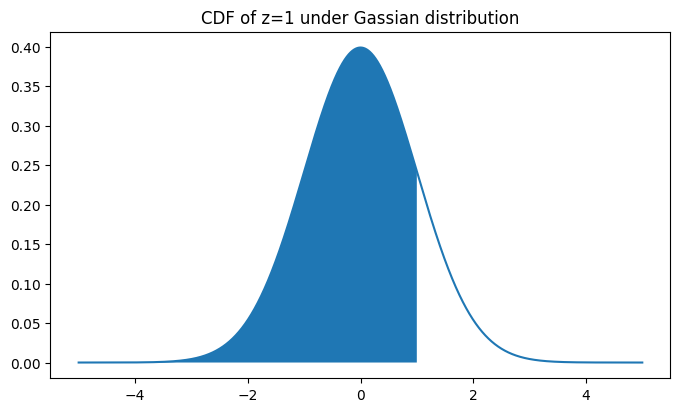

In [438]:
#create an array from -5 to 5 with interval of 0.001
n_range = np.arange(-5, 5, 0.001)

#plot the curve in matplotlib plotting chart
plt.figure(figsize = (8, 4.5))
plt.plot(n_range, st.norm.pdf(n_range, 0, 1))

#plot the area under curve between -5 to 1, to mimick the cdf of z-score = 3abs
plot_range = n_range[n_range< 1]
plt.fill_between(plot_range, 0, st.norm.pdf(plot_range, 0, 1))
plt.title('CDF of z=1 under Gassian distribution')
plt.show()

# Blog on 2 October 2023
## Simulation of multirules 

## 1. Creation of 10 million of standard Gaussian distribution

In [439]:
#import numpy and matplotlib
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import math

In [440]:
np.random.seed(42)
qc_list = dict()
for i in range(1, 7):
    qc_list['QC{}'.format(i)] = np.random.normal(0,1,size=1000000)

In [441]:
qc_df = pd.DataFrame(qc_list)

In [442]:
qc_df.head()

,QC1,QC2,QC3,QC4,QC5,QC6
0,0.496714,0.169172,1.064722,-1.107160,-0.184006,-0.202746
1,-0.138264,-0.121505,-0.496713,-1.769362,0.043793,0.910803
2,0.647689,1.156625,0.129260,-0.337808,1.182518,1.041890
3,1.523030,0.200086,-1.479693,0.502378,-0.284320,0.397202
4,-0.234153,0.864611,-0.309847,0.443503,-0.325154,0.360989


In [443]:
#Constructing QC rule check for each number of levels and rules

def qc_check(sd, length, qc_df=qc_df, qc_levels = [1,2,3,4,6]):
    
    for l in qc_levels:
        if length != 'R':
            #creating qc levels and multirule columns with default value False
            current_l_qc = 'QC_L={}_{}-{}s'.format(l, length, sd)
            qc_df[current_l_qc] = False
            
            #create a l-length violation list for storing number of the exceeding limits,
            #and a count for across qc violation
            within_qc_exceeds = [0]*l
            across_qc_exceeds = 0
            
            
            for row in range(len(qc_df)):
                current_exceeds = [0]*l
                    
                for n in range(1, l+1):
                    
                    current_qc_value = qc_df.loc[row, 'QC{}'.format(n)]
                                                 
                    #Calculating exceeding situations
                    if current_qc_value > sd:
                        current_exceeds[n-1] += 1
                    elif current_qc_value < -sd:
                        current_exceeds[n-1] -= 1
                    else:
                        current_exceeds[n-1] = 0
                    
                    #Adding number of excceding violations to within_qc_exceeds
                for i in range(len(current_exceeds)):
                    if current_exceeds[i]!= 0:
                        if within_qc_exceeds[i] > 0 and current_exceeds[i] > 0:
                            within_qc_exceeds[i] += current_exceeds[i]
                        elif within_qc_exceeds[i] < 0 and current_exceeds[i] < 0:
                            within_qc_exceeds[i] += current_exceeds[i]
                        else:
                            within_qc_exceeds[i] = current_exceeds[i]
                    else:
                        within_qc_exceeds[i] = 0
                
                #Determine within-QC level violation
                if max(within_qc_exceeds) >= length or min(within_qc_exceeds) <= -length:
                    qc_df.loc[row, current_l_qc] = True
                    within_qc_exceeds = [0]*l
                    across_qc_exceeds = 0
                
                    
                #Adding count to across-QC violation either 
                #1. if number of QC level exceeds > length limit (violation), 
                #2. or number of levels exceed limits + historical across qc violation in same direction > length limit
                #3.or all levels exceed limits in same direction
                current_positive_exceeds = sum(n>0 for n in current_exceeds)
                current_negative_exceeds = sum(n<0 for n in current_exceeds)
                #Procees #1: determine QC violation
                if l == 1 or length == 1:
                    pass
                elif current_positive_exceeds >= length or current_negative_exceeds >= length:
                    qc_df.loc[row, current_l_qc] = True
                    within_qc_exceeds = [0]*l
                    across_qc_exceeds = 0
                #Process #2: determine QC violation
                elif current_positive_exceeds + across_qc_exceeds >= length or (-current_negative_exceeds) + across_qc_exceeds <= -length:
                    qc_df.loc[row, current_l_qc] = True
                    within_qc_exceeds = [0]*l
                    across_qc_exceeds = 0
                #Process #3: Add to across_qc_exceeds
                elif abs(sum(current_exceeds)) == l:
                    #If same direction, add; if not, replace.
                    if sum(current_exceeds)*across_qc_exceeds >=0:
                        across_qc_exceeds += sum(current_exceeds)
                    else:
                        across_qc_exceeds = sum(current_exceeds)
                #Elsewhere situation will reset the across qc exceeds parameter
                else:
                    across_qc_exceeds = 0
            print('{}-{}s rule L={} checking completed'.format(length, sd, l))

        else:
            #Handling of R-4s
            qc_df['QC_L={}_R-4s'.format(l)] = False
            last_qcs = [0]*l
            reset = False
            for row in range(len(qc_df)):
                for i in range(1, l+1):
                    current_value = qc_df.loc[row, 'QC{}'.format(i)]
                    #Determine within-QC level violations
                    if abs(current_value - last_qcs[i-1]) > sd:
                        qc_df.loc[row, 'QC_L={}_R-4s'.format(l)] = True
                        reset = True
                    last_qcs[i-1] = current_value
                #Determine across-QC level violations
                if max(last_qcs) - min(last_qcs) > sd:
                    qc_df.loc[row, 'QC_L={}_R-4s'.format(l)] = True
                    reset = True
                #Execute reset
                if reset == True:
                    last_qcs = [0]*l
                    reset = False
            
            print('{}-{}s rule L={} checking completed'.format(length, sd, l))

In [444]:
#Check all the Multirules
qc_check(sd=3, length = 1)
qc_check(sd=2, length = 2)
qc_check(sd=4, length = 'R')
qc_check(sd=1, length = 4)
qc_check(sd=0, length = 10)

1-3s rule L=1 checking completed
1-3s rule L=2 checking completed
1-3s rule L=3 checking completed
1-3s rule L=4 checking completed
1-3s rule L=6 checking completed
2-2s rule L=1 checking completed
2-2s rule L=2 checking completed
2-2s rule L=3 checking completed
2-2s rule L=4 checking completed
2-2s rule L=6 checking completed
R-4s rule L=1 checking completed
R-4s rule L=2 checking completed
R-4s rule L=3 checking completed
R-4s rule L=4 checking completed
R-4s rule L=6 checking completed
4-1s rule L=1 checking completed
4-1s rule L=2 checking completed
4-1s rule L=3 checking completed
4-1s rule L=4 checking completed
4-1s rule L=6 checking completed
10-0s rule L=1 checking completed
10-0s rule L=2 checking completed
10-0s rule L=3 checking completed
10-0s rule L=4 checking completed
10-0s rule L=6 checking completed


In [445]:
print([sum(qc_df['QC_L={}_{}'.format(x, '10-0s')] == True) for x in [1, 2, 3, 4, 6]])

[951, 3186, 5562, 8459, 15551]


In [446]:
#Return results
individual_rule_dict = dict()
n_list = [1,2,3,4,6]
rule_list = ['1-3s', '2-2s', 'R-4s', '4-1s', '10-0s']
df_len = len(qc_df)

#Runing total numbers
for n in n_list:
    temp_list = []
    for rule in rule_list:
        temp_list.append(sum(qc_df['QC_L={}_{}'.format(n, rule)]))
    individual_rule_dict['n={}_total_number'.format(n)] = temp_list

#Running probability
for n in n_list:
    individual_rule_dict['n={}_probability'.format(n)] = [i/df_len for i in individual_rule_dict['n={}_total_number'.format(n)]]
    individual_rule_dict['n={}_ARL'.format(n)] = [round((1/i), 2) for i in individual_rule_dict['n={}_probability'.format(n)]]
    individual_rule_dict['n={}_95%CI'.format(n)] = ['{:.4f} - {:.4f}'.format(i-math.sqrt((i*(1-i)/df_len))*1.96,
                                                           i+math.sqrt((i*(1-i)/df_len))*1.96)
                                          for i in individual_rule_dict['n={}_probability'.format(n)]]
    

In [447]:
individual_rule_probabilities = pd.DataFrame(data = individual_rule_dict, 
                                             index= rule_list).transpose()

In [455]:
index_list_1 = []
for i in [1,2,3,4,6]:
    for j in ['_total_number', '_probability', '_95%CI', '_ARL']:
        index_list_1.append('n='+str(i)+j)
individual_rule_probabilities = individual_rule_probabilities.reindex(index_list_1)

In [456]:
individual_rule_probabilities

,1-3s,2-2s,R-4s,4-1s,10-0s
n=1_total_number,2638,960,4341,1062,951
n=1_probability,0.002638,0.00096,0.004341,0.001062,0.000951
n=1_95%CI,0.0025 - 0.0027,0.0009 - 0.0010,0.0042 - 0.0045,0.0010 - 0.0011,0.0009 - 0.0010
n=1_ARL,379.08,1041.67,230.36,941.62,1051.52
n=2_total_number,5422,2926,12190,3202,3186
n=2_probability,0.005422,0.002926,0.01219,0.003202,0.003186
n=2_95%CI,0.0053 - 0.0056,0.0028 - 0.0030,0.0120 - 0.0124,0.0031 - 0.0033,0.0031 - 0.0033
n=2_ARL,184.43,341.76,82.03,312.3,313.87
n=3_total_number,8101,5722,22727,6148,5562
n=3_probability,0.008101,0.005722,0.022727,0.006148,0.005562


In [457]:
for n in n_list:
    qc_list = ['QC_L={}_'.format(n)+i for i in ['1-3s', '2-2s', 'R-4s', '4-1s', '10-0s']]
    qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s'.format(n)] = qc_df[qc_list[0:3]].any(axis='columns')
    qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s/4-1s'.format(n)] = qc_df[qc_list[0:4]].any(axis='columns')
    qc_df.loc[:,'QC_L={}_1-3s/2-2s/R-4s/4-1s/10-x'.format(n)] = qc_df[qc_list[0:5]].any(axis='columns')

In [458]:
#Runing total numbers
multi_rule_list = ['1-3s', '1-3s/2-2s/R-4s', '1-3s/2-2s/R-4s/4-1s', '1-3s/2-2s/R-4s/4-1s/10-x']
multi_rule_dict = dict()

for n in n_list:
    temp_list = []
    for rule in multi_rule_list:
        temp_list.append(sum(qc_df['QC_L={}_{}'.format(n, rule)]))
    multi_rule_dict['n={}_total_number'.format(n)] = temp_list

#Running probability
for n in n_list:
    multi_rule_dict['n={}_probability'.format(n)] = [i/df_len for i in multi_rule_dict['n={}_total_number'.format(n)]]
    multi_rule_dict['n={}_ARL'.format(n)] = [round((1/i), 2) for i in multi_rule_dict['n={}_probability'.format(n)]]
    multi_rule_dict['n={}_95%CI'.format(n)] = ['{:.4f} - {:.4f}'.format(i-math.sqrt((i*(1-i)/df_len))*1.96,
                                                           i+math.sqrt((i*(1-i)/df_len))*1.96)
                                          for i in multi_rule_dict['n={}_probability'.format(n)]]

In [459]:
multi_rule_probabilities = pd.DataFrame(data = multi_rule_dict, 
                                             index= multi_rule_list).transpose()

In [460]:
multi_rule_probabilities = multi_rule_probabilities.reindex(index_list_1)

In [461]:
multi_rule_probabilities

,1-3s,1-3s/2-2s/R-4s,1-3s/2-2s/R-4s/4-1s,1-3s/2-2s/R-4s/4-1s/10-x
n=1_total_number,2638,7278,8313,9258
n=1_probability,0.002638,0.007278,0.008313,0.009258
n=1_95%CI,0.0025 - 0.0027,0.0071 - 0.0074,0.0081 - 0.0085,0.0091 - 0.0094
n=1_ARL,379.08,137.4,120.29,108.01
n=2_total_number,5422,17889,20914,24013
n=2_probability,0.005422,0.017889,0.020914,0.024013
n=2_95%CI,0.0053 - 0.0056,0.0176 - 0.0181,0.0206 - 0.0212,0.0237 - 0.0243
n=2_ARL,184.43,55.9,47.81,41.64
n=3_total_number,8101,30920,36659,41947
n=3_probability,0.008101,0.03092,0.036659,0.041947
